In [25]:
import numpy as np
from model_functions import *
from Classification_models_LOSO_2Class import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Bu not defterinde: göreceli bant gücü özelliklerini kullanarak veriler üzerinde farklı sınıflandırma yöntemlerini test ediyoruz. Ayrıca, farklı frekans bantları ve epok uzunlukları ile de denemeler yaptık ve burada yalnızca en iyi performansı gösterenleri rapor ediyoruz. Performansı Bir-Konu-Dışarıda Bırak çapraz doğrulama ile ölçüyoruz. Bu çapraz doğrulama yöntemi tüm denekler arasında yineleme yapar, her seferinde bir deneği dışarıda bırakır, veri kümesinin geri kalanını kullanarak bir model oluşturur ve ardından dışarıda bırakılan deneğe karşılık gelen veriler üzerinde bu modelin tahminleri için karışıklık matrisini hesaplar. Böyle bir çapraz doğrulamayı gerçekleştirmek için gerekli işlevler "Classification_models_functions_LOSO_2Class.py" dosyasında saklanmaktadır.

Aşağıdaki kod parçası göreceli bant gücü verilerini hesaplar ve config.py dosyasında yazdığınız dosya yoluna bilgisayarınıza kaydeder. Yalnızca bir kez çalıştırmanız ve ardından yorumlamanız gerekir. Kullanılan tüm fonksiyonlar model_functions dosyasında tanımlanmıştır.

In [26]:

subject_data, freqs, targets = load_data(duration=120,overlap=60,seg_length=4)
save_psds(subject_data,freqs,targets,'all_psds_very_long.pickle')


In [27]:
subject_data, freqs, targets = load_psds('all_psds_very_long.pickle')
test_labels = align_test_labels(classes=['A','C'])
features, targets = remove_class(subject_data,targets,'F')
features, targets = remove_test(features,targets,test_labels)
rbps = [relative_band_power(features[i],freqs,freq_bands=[0.5,4.0,7.0,9.0,11.0,13.0,25.0]) 
        for i in range(len(features))]

In [28]:
rbps = remove_channel(rbps, ['F3','F4', 'C4', 'F8'])

In [29]:
sum(rbps[i].shape[0] for i in range(len(rbps)))

702

In [30]:
rbps[1].shape

(12, 15, 6)

In [31]:
# Bu değişkenler, daha sonra çizmek üzere çeşitli modeller için doğrulukları ve ilgili modelleri kaydedecektir. 
accuracies = []
Models = []

Daha sonra tüm farklı sınıflandırma algoritmalarını deniyoruz. Gerekli fonksiyonlar Classification_models_LOSO_2Class dosyasındadır

### k nearest neighbor classifier

In [32]:
train_metric_dict, val_metric_dict = kNN_cross(rbps, targets, n_neighbors = 5, PCA_components = 0)
train_metric_dict, val_metric_dict

({'acc': 0.9776404151404151,
  'sens': 0.9892574444025631,
  'spec': 0.9640092879256966,
  'f1': 0.9794966294231532},
 {'acc': 0.7336182336182336,
  'sens': 0.7783641160949868,
  'spec': 0.6811145510835913,
  'f1': 0.7593307593307593})

In [33]:
Models += ['kNN']
accuracies += [val_metric_dict['acc']]

### Logistic Regression

In [34]:
train_metric_dict, val_metric_dict = log_reg_cross(rbps, targets, PCA_components = 85, reg_parameter = 1)
train_metric_dict, val_metric_dict

({'acc': 0.9878663003663004,
  'sens': 0.991424802110818,
  'spec': 0.9836908447589562,
  'f1': 0.9887925565658702},
 {'acc': 0.8304843304843305,
  'sens': 0.8575197889182058,
  'spec': 0.7987616099071208,
  'f1': 0.8452535760728218})

In [35]:
Models += ['log_reg']
accuracies += [val_metric_dict['acc']]

### SVM

In [36]:
train_metric_dict, val_metric_dict = svm_cross(rbps, targets,kernel='linear',
                                               reg_parameter=1.21)
train_metric_dict, val_metric_dict

({'acc': 0.9948361823361823,
  'sens': 0.9978797587636637,
  'spec': 0.9912649270234409,
  'f1': 0.995230375226146},
 {'acc': 0.8917378917378918,
  'sens': 0.9129287598944591,
  'spec': 0.8668730650154799,
  'f1': 0.9010416666666667})

In [37]:
Models += ['SVC']
accuracies += [val_metric_dict['acc']]

### Random Forest classifier

In [38]:
train_metric_dict, val_metric_dict = RF_cross(rbps, targets, n_estimators = 25, 
                                              min_samples_split = 4, PCA_components = 0)
train_metric_dict, val_metric_dict

({'acc': 0.999567562067562,
  'sens': 0.9998586505842443,
  'spec': 0.9992260061919505,
  'f1': 0.9995996137450247},
 {'acc': 0.7663817663817664,
  'sens': 0.7915567282321899,
  'spec': 0.7368421052631579,
  'f1': 0.7853403141361256})

In [39]:
Models += ['RF']
accuracies += [val_metric_dict['acc']]

### Multilayer Perceptron

In [40]:
train_metric_dict, val_metric_dict = mlp_cross(rbps, targets, PCA_components = 35, 
                                               max_iter = 600, hidden_layer_sizes=(3,1))
train_metric_dict, val_metric_dict

({'acc': 0.8947140822140822,
  'sens': 0.8684036939313984,
  'spec': 0.9255860238832375,
  'f1': 0.8990512426526182},
 {'acc': 0.6894586894586895,
  'sens': 0.6464379947229552,
  'spec': 0.739938080495356,
  'f1': 0.692090395480226})

In [41]:
Models += ['MLP']
accuracies += [val_metric_dict['acc']]

### Performance Plot

In [42]:
zipped_list = zip(accuracies, Models)
Models_s = [x for _,x in sorted(zipped_list)]
accuracies_s = sorted(accuracies)

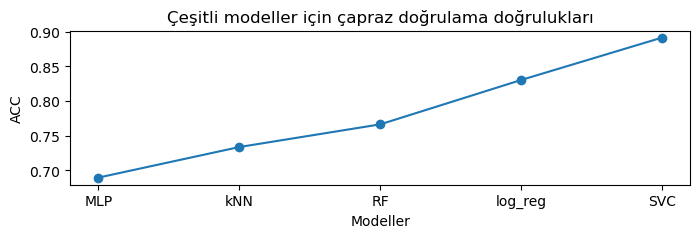

In [43]:
plt.figure(figsize = (8,2))
plt.plot(accuracies_s, '-o')
plt.xticks(ticks = [i for i in range(len(Models_s))], labels = Models_s)
plt.xlabel('Modeller')
plt.ylabel('ACC')
plt.title('Çeşitli modeller için çapraz doğrulama doğrulukları')
#plt.savefig('../Figures/Model_performances.png')
plt.show()